#### Implementation Pi-DeepOnet on Mechanical Vibrations 

### 1. Problem Setup

- Solve Spring Mass System(Forced response) by using PI-DeepOnet

In [ ]:
train_pth_name = 'normalize_PINN_2.pth'

### 2. Solve the spring mass system

#### 2-1. Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.init as init
%matplotlib inline

### 2-2. Random seed

In [2]:
seed = 2024
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 2-3. Define Parameter

In [3]:
# Properties
m = 1
c = 1
k = 1
mck_param = [m,c,k]
def F(t):
    F = torch.full_like(t, 2)
    return F

#### 2-4. Define Collocation ( sin, cos, k )

In [27]:
def DOMAIN_points(max_t, num_domain):
    domain_points = np.linspace(0, max_t, num_domain).reshape(-1, 1)
    return domain_points

max_t = 6
num_domain = 25

# Define domain 
domain_points = DOMAIN_points(max_t, num_domain)
bc_points_x0 = domain_points[0]
bc_points_x1 = domain_points[-1]

# Generate various condition (F = k)
num_condition = 8
F_t0 = np.linspace(-2,2,num_condition)
F_tn = np.linspace(2,-2,num_condition)

#### Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

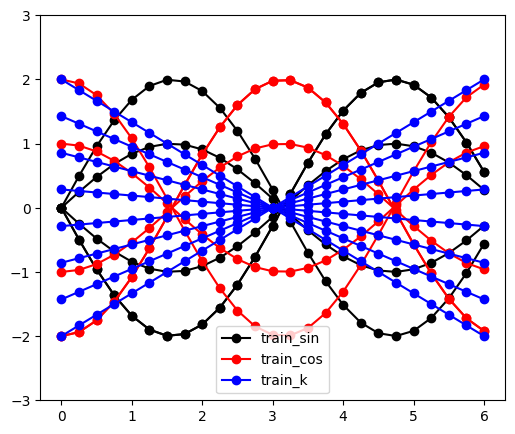

In [28]:
# sin(domain_points) * i 값을 계산하여 열로 쌓기
sin = np.hstack([np.sin(domain_points).reshape(-1, 1) * i for i in range(-2, 2+1)]) # 5개 그래프
cos = np.hstack([np.cos(domain_points).reshape(-1, 1) * i for i in range(-2, 2+1)])
k = np.hstack([np.linspace(i,j,num_domain).reshape(-1,1) for i,j in zip(F_t0, F_tn)])

plt.figure(figsize=(6,5))
plt.ylim(-3,3)
plt.plot(domain_points, sin[:,[0,1,3,4]], 'o-k') # 가운데 제외 (except, y = 0)
plt.plot(domain_points, sin[:,0], 'o-k', label = 'train_sin')
plt.plot(domain_points, cos[:,[0,1,3,4]], 'o-r') 
plt.plot(domain_points, cos[:,0], 'o-r', label = 'train_cos')
plt.plot(domain_points, k[:,[i for i in range(1,num_condition)]], 'o-b')
plt.plot(domain_points, k[:,[0]], 'o-b', label = 'train_k')
# plt.plot(domain_points, k, 'o-r', label = 'line')
plt.legend()
plt.show

In [29]:
train_sin = sin[:,[0,1,3,4]].T
train_cos = cos[:,[0,1,3,4]].T
train_k = k.T
total_ = np.concatenate((train_sin, train_cos, train_k), axis=0)
# total_ = train_k
print('sin shape :', train_sin.shape)
print('cos shape :', train_cos.shape)
print('k shape :', train_k.shape)
print('total_ shape :', total_.shape)
print('*********')

num_t = total_.shape[1] # num_t = num_domain
num_F_t = total_.shape[0]
print('num_t shape :', num_t)
print('num_F_t shape :', num_F_t)
print('**********')

# t, F(.),F(t) 
t_points = np.vstack(domain_points) # t[0]
t_ = np.vstack([t_points]*num_F_t) # t
F_ = np.vstack([np.vstack([total]*num_t) for total in total_]) # F(.)
F_t = (total_.flatten()).reshape(-1, 1) # F(t)

# t_train
t_train = np.concatenate((t_,F_,F_t), axis = 1)

print('t_[0] shape :', t_points.shape)
print('t_ shape :', t_.shape, f'-> ( num_t = {num_t} ) * ( num_F(t) = {num_F_t} ) = {num_t*num_F_t}')
print('F_ shape : ', F_.shape, f'-> ( num_F(t) = {num_F_t} ) * ( num_t = {num_t} ) = {num_t*num_F_t}')
print('F_t shape :', F_t.shape, f'-> ( F(t) flatten & reshape )')
print('t_train shape :', t_train.shape)


sin shape : (4, 25)
cos shape : (4, 25)
k shape : (8, 25)
total_ shape : (16, 25)
*********
num_t shape : 25
num_F_t shape : 16
**********
t_[0] shape : (25, 1)
t_ shape : (400, 1) -> ( num_t = 25 ) * ( num_F(t) = 16 ) = 400
F_ shape :  (400, 25) -> ( num_F(t) = 16 ) * ( num_t = 25 ) = 400
F_t shape : (400, 1) -> ( F(t) flatten & reshape )
t_train shape : (400, 27)


### 3. Data Generator 

In [30]:
# seed 고정 필요 시,
# generator = torch.Generator().manual_seed(seed) 

# initial Data
t_train_init = torch.tensor(t_train[t_train[:, 0] == 0], dtype=torch.float32)
ini_ds = DataLoader(t_train_init, batch_size=4, shuffle=True) # shuffle 시 마다 seed 다름

# domain Data
t_train_domain = torch.tensor(t_train, dtype=torch.float32)
train_ds = DataLoader(t_train_domain, batch_size=100, shuffle=True)

### 4. Define Network

#### 4-0. Define Device

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 4-1. Normalize Network

In [32]:
# Normalization data
class NormalizationLayer(nn.Module):
    def __init__(self, mean, variance):
        super().__init__()
        self.mean = torch.tensor(mean, dtype=torch.float32).to(device)
        self.std = torch.tensor(variance, dtype=torch.float32).sqrt().to(device)

    def forward(self, x):
        return (x - self.mean) / self.std

# BiasLayer 
class BiasLayer(nn.Module):
    def __init__(self):
        super().__init__()
        # 학습 가능한 바이어스를 초기화합니다.
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, inputs):
        # 입력에 바이어스를 추가합니다.
        return inputs + self.bias
    
# Branch Network
class BranchNetwork(nn.Module):
    def __init__(self, mean, variance):
        super().__init__()
        self.normalization = NormalizationLayer(mean, variance).to(device)
        self.dense_layers = nn.Sequential(
            nn.Linear(len(mean), 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh()
        )

        # 가중치 초기화
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.dense_layers:
            if isinstance(layer, nn.Linear):
                # Xavier 초기화 적용
                init.xavier_normal_(layer.weight)
                # 바이어스 0으로 초기화
                init.zeros_(layer.bias)
    
    def forward(self, x):
        x = self.normalization(x).to(device)
        x = self.dense_layers(x).to(device)
        return x

# Trunk Network
class TrunkNetwork(nn.Module):
    def __init__(self, mean, variance):
        super().__init__()
        self.normalization = NormalizationLayer(mean, variance)
        self.dense_layers = nn.Sequential(
            nn.Linear(len(mean), 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh()
        )

        # 가중치 초기화
        self._initialize_weights()
        
    def _initialize_weights(self):
        for layer in self.dense_layers:
            if isinstance(layer, nn.Linear):
                # Xavier 초기화 적용
                init.xavier_normal_(layer.weight)
                # 바이어스 0으로 초기화
                init.zeros_(layer.bias)
    
    def forward(self, x):
        x = self.normalization(x)
        x = self.dense_layers(x)
        return x

#### 4-2. Define PIDeepOnet 

In [ ]:
class PIDeepONet(nn.Module):
    def __init__(self, mean, var):
        super().__init__()
        
        # 브랜치와 트렁크 네트워크
        self.branch_network = BranchNetwork(mean['forcing'], var['forcing']).to(device)
        self.trunk_network = TrunkNetwork(mean['time'], var['time']).to(device)

        # 바이어스 레이어
        self.bias_layer = BiasLayer().to(device)

    def forward(self, forcing_input, time_input):
        forcing_input = forcing_input
        time_input = time_input

        # 브랜치와 트렁크 네트워크 통과
        branch_output = self.branch_network(forcing_input)
        trunk_output = self.trunk_network(time_input)

        # 내적 계산
        dot_product = torch.sum(branch_output * trunk_output, dim=1, keepdim=True)

        # 바이어스 추가
        output = self.bias_layer(dot_product)
        
        return output
    
def derivative(y, t) :
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(t), create_graph = True)[0] 
    return df

def requires_grad(x):
    return torch.tensor(x,requires_grad=True).to(device)

#### 4-3. Define PDE & BC 

In [34]:
def BC(X_init, model):
    # BC
    F_bc_init = X_init[:, 1:-1].to(device)
    t_bc_init = X_init[:, :1].to(device)

    # requires_grad (x(0) = 0)
    F_bc_init = requires_grad(F_bc_init)
    t_bc_init = requires_grad(t_bc_init)

    # x(0) (predict)
    x_0 = model(F_bc_init, t_bc_init)
    x_t_0 = derivative(x_0, t_bc_init)
    # print('x_0:', x_0)

    return [x_0.float(), x_t_0.float()]

In [ ]:
def PDE(X, model, mck_param):
    # PDE
    F_PDE = X[:, 1:-1].to(device)
    t_PDE = X[:, :1].to(device)
    F_t_PDE = X[:, -1].reshape(-1,1).to(device)

    # requires_grad (F(t))
    F_PDE = requires_grad(F_PDE)
    t_PDE = requires_grad(t_PDE)
    F_t_PDE = requires_grad(F_t_PDE)

    # x(t), x'(t), x''(t) (predict)
    x_pred = model(F_PDE, t_PDE)
    x_t = derivative(x_pred, t_PDE)
    x_tt = derivative(x_t, t_PDE)

    m = torch.full_like(x_tt, mck_param[0])
    c = torch.full_like(x_t, mck_param[1])
    k = torch.full_like(x_pred, mck_param[2])

    PDE_residual = m * x_tt + c * x_t + k * x_pred - F_t_PDE

    return [PDE_residual.float()]


In [36]:
# scaling - (mean,var)
mean = {
    'forcing': torch.mean(t_train_domain[:, 1:-1], dim=0),
    'time': torch.mean(t_train_domain[:, :1], dim=0)
}

var = {
    'forcing': torch.var(t_train_domain[:, 1:-1], dim=0),
    'time': torch.var(t_train_domain[:, :1], dim=0)
}

In [37]:
# scaling - (mean,var)
mean = {
    'forcing': torch.mean(t_train_domain[:, 1:-1], dim=0),
    'time': torch.mean(t_train_domain[:, :1], dim=0)
}

var = {
    'forcing': torch.var(t_train_domain[:, 1:-1], dim=0),
    'time': torch.var(t_train_domain[:, :1], dim=0)
}

# device 지정
PI_DeepONet = PIDeepONet(mean, var) # 이미 f,t 에 대한 mean,var 을 모델에 저장
PI_DeepONet = PI_DeepONet.to(device)

print(PI_DeepONet)

/var/tmp/ipykernel_12748/365301512.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float32).to(device)


PIDeepONet(
  (branch_network): BranchNetwork(
    (normalization): NormalizationLayer()
    (dense_layers): Sequential(
      (0): Linear(in_features=25, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Tanh()
    )
  )
  (trunk_network): TrunkNetwork(
    (normalization): NormalizationLayer()
    (dense_layers): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Tanh()
    )
  )
  (bias_layer): BiasLayer()
)


/var/tmp/ipykernel_12748/365301512.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(variance, dtype=torch.float32).sqrt().to(device)


### 6. Train

C:\Users\Son\AppData\Local\Temp\ipykernel_35824\31768229.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x,requires_grad=True).to(device)


Epoch: 10 Loss: 0.856905 PDELoss: 0.687758 BCLoss: 0.016915
Epoch: 20 Loss: 0.832809 PDELoss: 0.814941 BCLoss: 0.001787
Epoch: 30 Loss: 0.884673 PDELoss: 0.877283 BCLoss: 0.000739
Epoch: 40 Loss: 0.771239 PDELoss: 0.766034 BCLoss: 0.000521
Epoch: 50 Loss: 0.955978 PDELoss: 0.944258 BCLoss: 0.001172
Epoch: 60 Loss: 0.902658 PDELoss: 0.878575 BCLoss: 0.002408
Epoch: 70 Loss: 0.646799 PDELoss: 0.618467 BCLoss: 0.002833
Epoch: 80 Loss: 0.867975 PDELoss: 0.835458 BCLoss: 0.003252
Epoch: 90 Loss: 0.608472 PDELoss: 0.582228 BCLoss: 0.002624
Epoch: 100 Loss: 0.776795 PDELoss: 0.747844 BCLoss: 0.002895
Epoch: 110 Loss: 0.569739 PDELoss: 0.546459 BCLoss: 0.002328
Epoch: 120 Loss: 0.588330 PDELoss: 0.577325 BCLoss: 0.001101
Epoch: 130 Loss: 0.749785 PDELoss: 0.711693 BCLoss: 0.003809
Epoch: 140 Loss: 0.454847 PDELoss: 0.433628 BCLoss: 0.002122
Epoch: 150 Loss: 0.315991 PDELoss: 0.300765 BCLoss: 0.001523
Epoch: 160 Loss: 0.449391 PDELoss: 0.414635 BCLoss: 0.003476
Epoch: 170 Loss: 0.968461 PDELoss

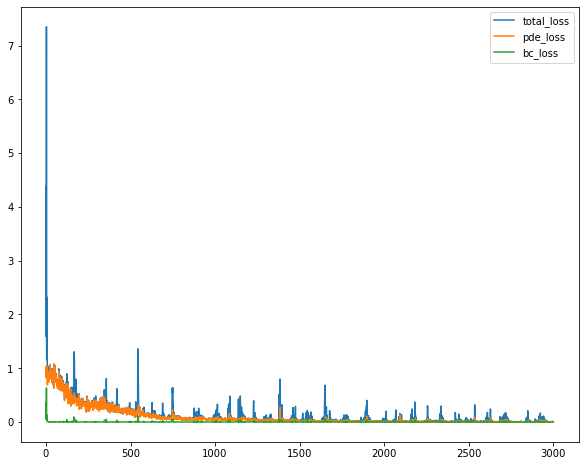

In [ ]:
# max_loss
max_loss = np.inf

# 옵티마이저 설정
Loss_func = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(PI_DeepONet.parameters(), lr=1e-3)

# 학습률 감소 스케줄러
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=30)

# Train
total_loss = []
pdeloss_list = []
bcloss_list = []
n_epochs = 3000
for epoch in range(1,n_epochs+1):
     
    PI_DeepONet.train()
    
    # Load dataset
    for X_init,X in zip(ini_ds, train_ds):
        # Data to device
        X_init = X_init.to(device)
        X = X.to(device)

        # Calculate BC/ x(0)=0, x'(0)=0
        Loss_BC = BC(X_init, PI_DeepONet) # BC = [x_0, x_t_0] 
        loss_bc1 = Loss_func(Loss_BC[0], torch.zeros_like(Loss_BC[0]).to(device))
        loss_bc2 = Loss_func(Loss_BC[1], torch.zeros_like(Loss_BC[1]).to(device))
        loss_bc = loss_bc1 + loss_bc2

        # Calculate PDE/ m(x'')+c(x')+k(x)-F = 0
        Loss_PDE = PDE(X, PI_DeepONet, mck_param) # PDE = [PDE Loss, Governing equation] 
        loss_pde = Loss_func(Loss_PDE[0], torch.zeros_like(Loss_PDE[0]).to(device))
        # or loss = nn.MSELoss(reduction='mean')({outputs}, {labels})

        # Final Loss func.
        loss = loss_pde + 10 * loss_bc

        optimizer.zero_grad() # 이전 배치의 기울기 0으로 초기화
        loss.backward() # loss func 기준으로 각 파라미터에 대한 gradient 계산 (=backprop)
        optimizer.step() # 모델의 파라미터 조정

        if loss.item() < max_loss:
            save_path = './'
            torch.save(PI_DeepONet.state_dict(), save_path+f'{train_pth_name}.pth')
            max_loss = loss.item()
            
            # print("model save")
        
    if epoch % 10 == 0:
        print('Epoch: {} Loss: {:.6f} PDELoss: {:.6f} BCLoss: {:.6f}'.format(epoch, loss.item(), loss_pde.item(), loss_bc.item()))
    
    total_loss.append(loss.item())
    pdeloss_list.append(loss_pde.item())
    bcloss_list.append(loss_bc.item())

plt.figure(figsize = (10, 8))
plt.plot(total_loss, label = 'total_loss')
plt.plot(pdeloss_list, label = 'pde_loss')
plt.plot(bcloss_list, label = 'bc_loss')
plt.legend()
plt.show()
# optimizer = optim.Adam(list(branch_net.parameters()) + list(trunk_net.parameters()), lr=1e-4)
# Loss_func = nn.MSELoss(reduction='mean')


### 7. Test

In [ ]:
test_pth_path= './normalize_PINN_2.pth'

#### 7-0 exact_solution_func

In [39]:
from scipy.integrate import solve_ivp
import numpy as np

# 질량-감쇠-스프링 시스템
def mass_damper_system(t, y, m, c, k, F_array, t_array):
    x, dxdt = y
    F = np.interp(t, t_array, F_array)  # t에 맞는 F값을 np.interp로 가져옴
    d2xdt2 = (F - c * dxdt - k * x) / m
    return [dxdt, d2xdt2]

# ODE를 푸는 함수
def solve_mass_damper(m, c, k, F_array, t_array, t_span, y0, t_eval):
    return solve_ivp(mass_damper_system, t_span, y0, t_eval=t_eval, args=(m, c, k, F_array, t_array))


#### 7-1 Test 1

In [40]:
test_t = torch.linspace(0,6,25).unsqueeze(1)
test_k = torch.from_numpy((train_k[0,:])).unsqueeze(0).repeat(num_domain,1).float()

test_t = requires_grad(test_t)
test_k = requires_grad(test_k)

print('test_t shape :', test_t.shape)
print('test_k shape :', test_k.shape)

test_t shape : torch.Size([25, 1])
test_k shape : torch.Size([25, 25])


/var/tmp/ipykernel_12748/31768229.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x,requires_grad=True).to(device)


In [41]:
# 외부 힘을 numpy array로 정의 (예: sin(t)에서 값을 계산한 배열)
t_array = np.linspace(0, 6, 25)  # 시간 배열
F_array = train_k[0,:]  # sin(t)의 값을 가진 힘 배열

# 초기 조건
y0 = [0, 0]  # [x(0), dx/dt(0)]

# 시간 범위
t_span = (0, 6)
t_eval = np.linspace(0, 6, 25)

# ODE 풀기
solution = solve_mass_damper(m=1, c=1, k=1, F_array=F_array, t_array=t_array, t_span=t_span, y0=y0, t_eval=t_eval)


/var/tmp/ipykernel_12748/365301512.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float32).to(device)
/var/tmp/ipykernel_12748/365301512.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(variance, dtype=torch.float32).sqrt().to(device)
/var/tmp/ipykernel_12748/2414990479.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

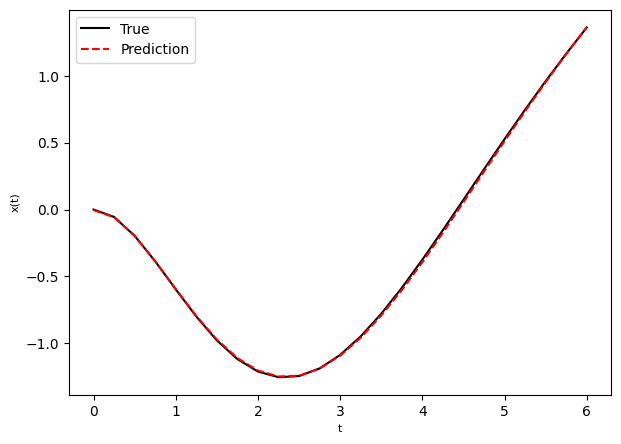

In [47]:
test_model = PIDeepONet(mean, var)
model_path = test_pth_path
test_model.load_state_dict(torch.load(model_path))
test_model.eval()

pred = test_model(test_k, test_t)

plt.figure(figsize=(7, 5))
# plt.plot(test_t.cpu().detach().numpy(), exact_solution(test_t), '-k', label='True')
plt.plot(solution.t, solution.y[0], '-k', label='True')
plt.plot(test_t.cpu().detach().numpy(), pred.cpu().detach().numpy(), '--r', label='Prediction')
plt.legend()
plt.xlabel('t', fontsize=8)
plt.ylabel('x(t)', fontsize=8)
plt.show()

#### 7-2 Test 2

In [48]:
test_t = torch.linspace(0, 6, 25).unsqueeze(1).float()
curve_F = 1.5*torch.cos(test_t)

In [49]:
test_t = test_t
test_unseen_array_F = curve_F
test_unseen_F =test_unseen_array_F.reshape(-1,25).repeat(25,1).float()

test_t = requires_grad(test_t)
test_unseen_F = requires_grad(test_unseen_F)

print('test_t shape :', test_t.shape)
print('test_unseen_F shape :', test_unseen_array_F.shape)
print('test_unseen shape :', test_unseen_F.shape)

test_t shape : torch.Size([25, 1])
test_unseen_F shape : torch.Size([25, 1])
test_unseen shape : torch.Size([25, 25])


/var/tmp/ipykernel_12748/31768229.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x,requires_grad=True).to(device)


In [50]:
# 외부 힘을 numpy array로 정의 (예: sin(t)에서 값을 계산한 배열)
t_array = np.linspace(0, 6, 25)  # 시간 배열
F_array = test_unseen_array_F.numpy().reshape(25)  # 힘 배열

# 초기 조건
y0 = [0, 0]  # [x(0), dx/dt(0)]

# 시간 범위
t_span = (0, 6)
t_eval = np.linspace(0, 6, 25)

# ODE 풀기
solution = solve_mass_damper(m=1, c=1, k=1, F_array=F_array, t_array=t_array, t_span=t_span, y0=y0, t_eval=t_eval)


/var/tmp/ipykernel_12748/365301512.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean, dtype=torch.float32).to(device)
/var/tmp/ipykernel_12748/365301512.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(variance, dtype=torch.float32).sqrt().to(device)
/var/tmp/ipykernel_12748/2916565553.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details)

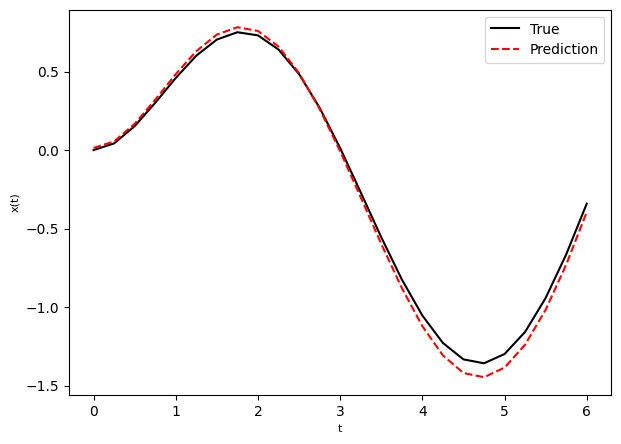

In [52]:
test_model = PIDeepONet(mean, var)
model_path = test_pth_path
test_model.load_state_dict(torch.load(model_path))
test_model.eval()

pred = test_model(test_unseen_F, test_t)

plt.figure(figsize=(7, 5))
# plt.plot(test_t.cpu().detach().numpy(), exact_solution(test_t), '-k', label='True')
plt.plot(solution.t, solution.y[0], '-k', label='True')
plt.plot(test_t.cpu().detach().numpy(), pred.cpu().detach().numpy(), '--r', label='Prediction')
plt.legend()
plt.xlabel('t', fontsize=8)
plt.ylabel('x(t)', fontsize=8)
plt.show()